# Estimating Snow Depth from ICESat-2 ATL08QL data

This script is made to derive preliminary snow depth estimates using the ATL08 Quick Look product. Because the quick looks are (a) subject to geolocation errors and (b) automatically deleted after the final data release, it is recommended to use "is2_snowex_ak.ipynb" if it has been ~45 days since the RGT of interest.

icepyx normally does not support downloading of ATL08QL data, so a slightly altered version is required. The user may find a branch with ATL08QL functionality at: https://github.com/zachghiaccio/icepyx/tree/quick-looks. A pull request for this feature will be introduced to the icepyx development team in the near future.

When ATL08QL functionality is introduced to icepyx, it is planned to integrate this notebook with "is2_snowex_ak.ipynb".

As with the above notebook, snow-on/-off DEMs from the UAF airborne lidar are needed to run this script. Interested users should contact the original provider of the data (Chris Larsen, cflarsen@uaf.edu).

In [40]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import rioxarray as rio
import os
from osgeo import gdal
import icepyx as ipx
import pandas as pd
import pickle
from pyproj import Proj, transform, Transformer, CRS
import sys

sys.path.append('C:/Users/zfair/OneDrive - NASA/Documents/Python/icesat2-snow/')
import lidar_processing as lp

To keep things simple, we are not using cloud services to obtain the ATL08QL data - the data will be downloaded to our workspace. Once this notebook is integrated, the hope is to allow cloud access to quick look data.

In [2]:
# Specify the ICESat-2 product
short_name = 'ATL08QL'

# Define the spatial extent using a pre-generated bounding box
with open('C:/Users/zfair/OneDrive - NASA/Documents/Python/icesat2-snow/Data/shapefiles/snowex_sites_for_icepyx.pkl', 'rb') as f:
    coordinates = pickle.load(f)
    spatial_extent = coordinates['alaska']
    
# Date range of requested data
date_range = ['2023-03-01', '2023-03-31']

# ICESat-2 track (RGT, optional)
rgt = '1356'
    
# Generate the query object
try:
    # With RGT specification
    region = ipx.Query(short_name, spatial_extent, date_range, tracks=rgt)
except:
    # General query
    region = ipx.Query(short_name, spatial_extent, date_range)
    
print(region)

Product ATL08QL v006
('bounding box', [-149.65, 64.587, -147.233, 70.202])
Date range ['2023-03-01', '2023-03-31']


In [3]:
# Enter login information for Earthdata
uid = 'zhfair'
email = 'zhfair@umich.edu'
region.earthdata_login(uid, email)

In [10]:
# Check the ids for the requested data
region.avail_granules(ids=True)

date_str = region.avail_granules(ids=True)[0][0][8:16]
print(date_str)

20230319


In [5]:
# Start the data order
region.order_granules()

Total number of data order requests is  1  for  1  granules.
Data request  1  of  1  is submitting to NSIDC
order ID:  5000004041869
Initial status of your order request at NSIDC is:  processing
Your order status is still  processing  at NSIDC. Please continue waiting... this may take a few moments.
Your order is: complete


In [6]:
# Download the granules into the specified folder
path = 'C:/Users/zfair/OneDrive - NASA/Documents/Python/icesat2-snow/Data/is2/icepyx/'
region.download_granules(path)

Beginning download of zipped output...
Data request 5000004041869 of  1  order(s) is downloaded.
Download complete


Now that our data is downloaded, let's load the file into a DataFrame.

In [35]:
# Find file in saved directory
for fname in os.listdir(path):
    if rgt and date_str in fname:
        is2_file = path + fname
                    
print(is2_file)
                    
# Load the ATL08QL data into a DataFrame
with h5py.File(is2_file, 'r') as f:
    # Identify the strong beams
    sc_orient = f['orbit_info/sc_orient'][0]
    strong_beams, strong_ids = lp.strong_beam_finder(sc_orient)
    
    # Concatenate strong beam data into DataFrame
    atl08 = lp.beam_cycle_concat([is2_file], 'ATL08')
    
atl08.head()

C:/Users/zfair/OneDrive - NASA/Documents/Python/icesat2-snow/Data/is2/icepyx/processed_ATL08QL_20230319082559_13561805_006_01.h5


,lat,lon,height,delta_time,gt,time
0,65.979050,-147.233124,346.491516,1.644498e+08,1,2023-03-19 08:29:39.197503584
1,65.978157,-147.233368,349.682220,1.644498e+08,1,2023-03-19 08:29:39.211603552
2,65.977264,-147.233612,337.419403,1.644498e+08,1,2023-03-19 08:29:39.225698944
3,65.976379,-147.233871,341.231598,1.644498e+08,1,2023-03-19 08:29:39.239799712
4,65.975487,-147.234116,351.328186,1.644498e+08,1,2023-03-19 08:29:39.253903200


In [41]:
# Add easting/northing coordinates (EPSG:32606)
transformer = Transformer.from_crs('EPSG:4326', 'EPSG:32606', always_xy=True)

atl08['x'], atl08['y'] = transformer.transform(atl08.lon, atl08.lat)

atl08.head()

,lat,lon,height,delta_time,gt,time,x,y
0,65.979050,-147.233124,346.491516,1.644498e+08,1,2023-03-19 08:29:39.197503584,489410.652194,7.317595e+06
1,65.978157,-147.233368,349.682220,1.644498e+08,1,2023-03-19 08:29:39.211603552,489399.192308,7.317495e+06
2,65.977264,-147.233612,337.419403,1.644498e+08,1,2023-03-19 08:29:39.225698944,489387.731650,7.317396e+06
3,65.976379,-147.233871,341.231598,1.644498e+08,1,2023-03-19 08:29:39.239799712,489375.580210,7.317297e+06
4,65.975487,-147.234116,351.328186,1.644498e+08,1,2023-03-19 08:29:39.253903200,489364.117988,7.317198e+06


In [47]:
# Remove messy ICESat-2 data
upper = atl08.height.mean() + 3*atl08.height.std()
atl08 = atl08.loc[atl08.height<upper]

# Add vertical height correction needed for quick-look products
atl08['height'] += 2.7

Our ICESat-2 data is now ready! Let's load up a snow-off DEM from the UAF airborne lidar.

In [48]:
# Load UAF lidar data into a raster. Will be updated to be more flexible at a later date.
f_snow_off = 'C:/Users/zfair/OneDrive - NASA/Documents/Python/icesat2-snow/Data/UAF/farmersloop_2022may28_dtm.tif'
f_snow_on = 'C:/Users/zfair/OneDrive - NASA/Documents/Python/icesat2-snow/Data/UAF/farmersloop_2022oct24_snowdepth.tif'

lidar_snow_off = rio.open_rasterio(f_snow_off)
lidar_snow_on = rio.open_rasterio(f_snow_on)

lidar_snow_off

<xarray.DataArray (band: 1, y: 6778, x: 8692)>
[58914376 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 4.643e+05 4.643e+05 ... 4.686e+05 4.686e+05
  * y            (y) float64 7.196e+06 7.196e+06 ... 7.193e+06 7.193e+06
    spatial_ref  int32 0
Attributes:
    _FillValue:    -9999.0
    scale_factor:  1.0
    add_offset:    0.0

In [49]:
# Apply vertical datum correction. To be updated to be more flexible.
lidar_snow_off -= 9.75

# Coregister with ICESat-2 using a bivariate spline
strong_ids = np.unique(atl08['gt'])
atl08_uaf = lp.coregister_is2(lidar_snow_off, lidar_snow_on, atl08, strong_ids)

atl08_uaf.head()

,time,x,y,lidar_height,lidar_snow_depth,is2_height,beam,residual,slope
1698,2023-03-19 08:29:56.502261280,468454.665777,7.196202e+06,-9998.800000,-9999.000000,173.215744,5,10172.015744,NaN
1699,2023-03-19 08:29:56.516360704,468442.780291,7.196103e+06,171.989402,0.201575,171.186295,5,-0.803108,-2.029449
1700,2023-03-19 08:29:56.530461504,468430.894093,7.196004e+06,172.385286,0.192406,171.545044,5,-0.840242,-0.835350
1701,2023-03-19 08:29:56.544562912,468419.007183,7.195904e+06,174.626694,0.071893,173.720490,5,-0.906205,0.187299
1702,2023-03-19 08:29:56.558663552,468407.119562,7.195805e+06,176.915327,0.000459,176.182144,5,-0.733183,0.846700


In [50]:
# Remove filler data
atl08_uaf['lidar_height'][atl08_uaf['lidar_height']<0] = np.nan
atl08_uaf['lidar_snow_depth'][atl08_uaf['lidar_snow_depth']<0] = np.nan
atl08_uaf['residual'][atl08_uaf['residual']>100] = np.nan

atl08_uaf.head()

C:\Users\zfair\AppData\Local\Temp\1/ipykernel_21560/3545285094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atl08_uaf['lidar_height'][atl08_uaf['lidar_height']<0] = np.nan
C:\Users\zfair\AppData\Local\Temp\1/ipykernel_21560/3545285094.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  atl08_uaf['lidar_snow_depth'][atl08_uaf['lidar_snow_depth']<0] = np.nan
C:\Users\zfair\AppData\Local\Temp\1/ipykernel_21560/3545285094.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

,time,x,y,lidar_height,lidar_snow_depth,is2_height,beam,residual,slope
1698,2023-03-19 08:29:56.502261280,468454.665777,7.196202e+06,NaN,NaN,173.215744,5,NaN,NaN
1699,2023-03-19 08:29:56.516360704,468442.780291,7.196103e+06,171.989402,0.201575,171.186295,5,-0.803108,-2.029449
1700,2023-03-19 08:29:56.530461504,468430.894093,7.196004e+06,172.385286,0.192406,171.545044,5,-0.840242,-0.835350
1701,2023-03-19 08:29:56.544562912,468419.007183,7.195904e+06,174.626694,0.071893,173.720490,5,-0.906205,0.187299
1702,2023-03-19 08:29:56.558663552,468407.119562,7.195805e+06,176.915327,0.000459,176.182144,5,-0.733183,0.846700


<AxesSubplot:xlabel='y', ylabel='residual'>

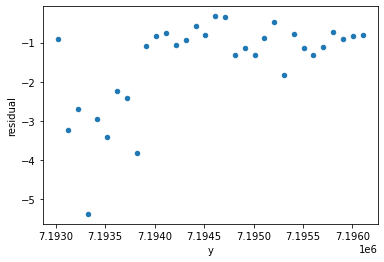

In [51]:
atl08_uaf.plot.scatter(x='y', y='residual')